In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df = pd.read_csv("/content/gdrive/MyDrive/project/ALI/data_covid.csv", index_col=[0])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# create new dataframe for this stage
df1 = df

In [8]:
df1['b1'] = df1['brand1'].notnull()
df1['b2'] = df1['brand2'].notnull()
df1['b3'] = df1['brand3'].notnull()

In [9]:
from sklearn.preprocessing import StandardScaler

scaled_features = df1.copy()

col_names = ['age']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features

In [10]:
X = scaled_features[['state','age','comorb','b1','b2','b3']]
y = scaled_features['death']

In [13]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

In [14]:
X, y = sampler.fit_resample(X, y)

In [10]:
y.value_counts()

0    35585
1    35585
Name: death, dtype: int64

In [11]:
y.value_counts()/len(y)

0    0.5
1    0.5
Name: death, dtype: float64

In [13]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    accuracy_score,
)

# define a function to calculate evaluation metrics
def test_eval(clf_model, y_test, y_pred, algo=None, results=None, show_results=True):
    if results is None:
        # create a dataframe to store results
        results = pd.DataFrame(
            columns=[
                "algo",
                "accuracy",
                "precision",
                "recall",
                "F1score",
                "confusion_matrix",
            ]
        )

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1score = f1_score(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)

    # store results
    results = results.append(
        {
            "algo": algo,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "F1score": F1score,
            "confusion_matrix": cf_matrix,
        },
        ignore_index=True,
    )

    # print results
    if show_results:
        print(
            "Confusion Matrix",
            "\n",
            "=" * 60,
            "\n",
            confusion_matrix
        )
        
        print(
            "Classification Report\n",
            "=" * 60,
            "\n",
            classification_report(y_test, y_pred),
        )

    return results


In [15]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier


In [16]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=9)
y_rf_pred = cross_val_predict(rf_model, X, y, cv=5)

In [17]:
results = test_eval(rf_model, y, y_rf_pred, 'Random Forest')

Confusion Matrix 
 <function confusion_matrix at 0x7f43d89f98c0>
Classification Report
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     35585
           1       0.89      0.88      0.88     35585

    accuracy                           0.88     71170
   macro avg       0.88      0.88      0.88     71170
weighted avg       0.88      0.88      0.88     71170



In [18]:
svm_model = SVC()
y_svm_pred = cross_val_predict(svm_model, X, y, cv=5)

In [19]:
results = test_eval(svm_model, y, y_svm_pred, 'SVM', results=results)

Confusion Matrix 
 <function confusion_matrix at 0x7f43d89f98c0>
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.89      0.87     35585
           1       0.88      0.86      0.87     35585

    accuracy                           0.87     71170
   macro avg       0.87      0.87      0.87     71170
weighted avg       0.87      0.87      0.87     71170



In [20]:
lr_model = LogisticRegression()
y_lr_pred = cross_val_predict(lr_model, X, y, cv=5)

In [21]:
results = test_eval(lr_model, y, y_lr_pred, 'Logistic Regression', results=results)

Confusion Matrix 
 <function confusion_matrix at 0x7f43d89f98c0>
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     35585
           1       0.88      0.85      0.86     35585

    accuracy                           0.87     71170
   macro avg       0.87      0.87      0.87     71170
weighted avg       0.87      0.87      0.87     71170



In [22]:
Knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ) 
y_knn_pred = cross_val_predict(Knn_model, X, y, cv=5)

In [23]:
results = test_eval(Knn_model, y, y_knn_pred, ' knn', results=results)

Confusion Matrix 
 <function confusion_matrix at 0x7f43d89f98c0>
Classification Report
               precision    recall  f1-score   support

           0       0.80      0.95      0.87     35585
           1       0.94      0.76      0.84     35585

    accuracy                           0.85     71170
   macro avg       0.87      0.85      0.85     71170
weighted avg       0.87      0.85      0.85     71170



In [24]:
results

,algo,accuracy,precision,recall,F1score,confusion_matrix
0,Random Forest,0.882254,0.885220,0.878404,0.881799,"[[31532, 4053], [4327, 31258]]"
1,SVM,0.870521,0.882351,0.855051,0.868487,"[[31528, 4057], [5158, 30427]]"
2,Logistic Regression,0.866643,0.877234,0.852606,0.864745,"[[31339, 4246], [5245, 30340]]"
3,knn,0.853632,0.939140,0.756274,0.837845,"[[33841, 1744], [8673, 26912]]"


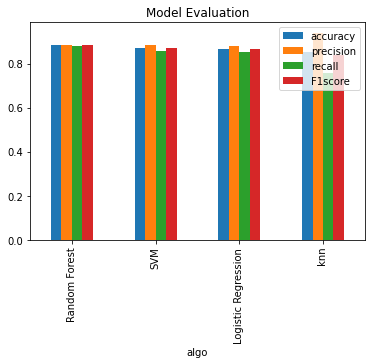

In [25]:
# plot group bar chart for accuracy, precision, recall and F1 score
results.plot(x="algo", y=["accuracy", "precision", "recall", "F1score"], kind="bar", title="Model Evaluation")

In [26]:
from sklearn.metrics import plot_roc_curve

In [28]:
rf_model.fit(X, y);
svm_model.fit(X, y);
lr_model.fit(X, y);
Knn_model.fit(X, y);


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

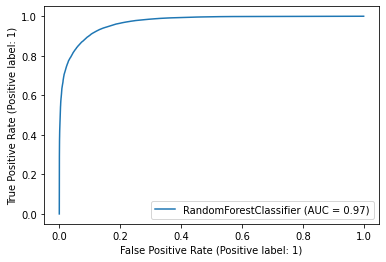

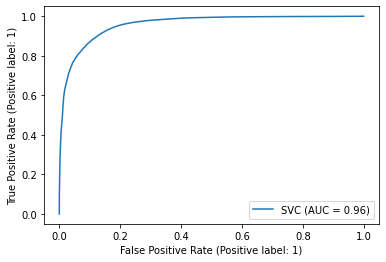

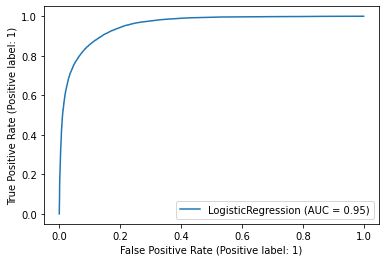

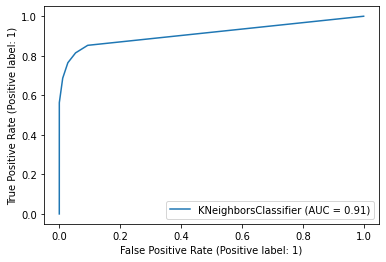

In [29]:
disp = plot_roc_curve(rf_model, X, y)
plot_roc_curve(svm_model, X, y);
plot_roc_curve(lr_model, X, y);
plot_roc_curve(Knn_model, X, y);

In [20]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier(n_estimators=50, max_depth=9)
cv = StratifiedKFold(n_splits=5,shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


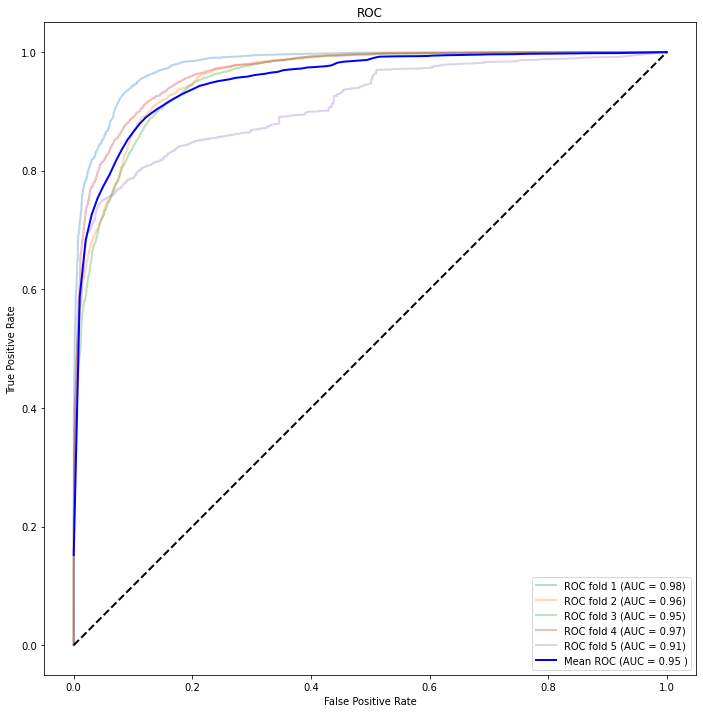

In [23]:
import matplotlib.patches as patches
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')


tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X,y):
    prediction = clf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier(n_estimators=50, max_depth=9)
cv = StratifiedKFold(n_splits=5,shuffle=False)

In [ ]:
import matplotlib.patches as patches
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')


tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X,y):
    prediction = clf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

KeyError: ignored

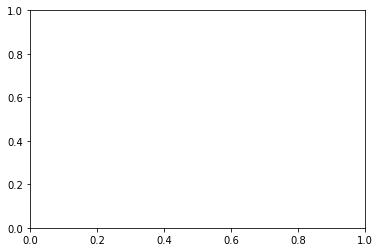

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(n_estimators=50, max_depth=9)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()